In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import utils as ut

In [2]:
ds_mld = xr.open_dataset('Data/cesm_mld.nc')

In [3]:
mld_climo = ds_mld.groupby('time.month').mean('time')['mld']
lon = ds_mld['lon']
lat = ds_mld['lat']

### Plotting the monthly MLD values

Text(0.5, 0.98, 'Mixed Layer Depth')

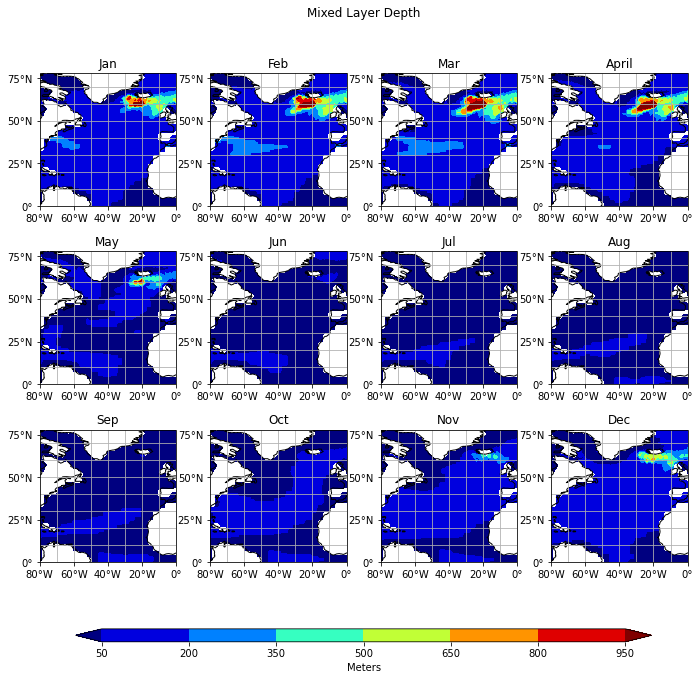

In [4]:
fig,ax = plt.subplots(nrows=3,ncols=4,subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(10,9))
ax = ax.flatten()

clevs = np.arange(50,951,150)
months = ['Jan','Feb','Mar','April','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for i, mon in enumerate(months):
    ax[i].set_extent([-80,0,0,75])
    cs = ax[i].contourf(lon,lat,mld_climo[i]/100,cmap='jet',transform=ccrs.PlateCarree(),extend='both',levels=clevs)
    
    #Longitude Labels
    ax[i].set_xticks(np.arange(-80,1,20),crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax[i].xaxis.set_major_formatter(lon_formatter)
    
    #Latitude Labels
    ax[i].set_yticks(np.arange(0,76,25),crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax[i].yaxis.set_major_formatter(lat_formatter)

    
    ax[i].coastlines()
    ax[i].gridlines()
    ax[i].set_title(mon)
    
#Make room for colorbar
fig.subplots_adjust(bottom=0.1,top=0.9,left=0.05,right=0.95,wspace=0.25,hspace=0.1)
cbar_ax = fig.add_axes([0.1,0,0.8,0.02])
cbar=fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='Meters')
plt.suptitle('Mixed Layer Depth')
#fig.tight_layout()


### Plotting the seasonal MLD values

Text(0.5, 0.98, 'Seasonal Mixed Layer Depth')

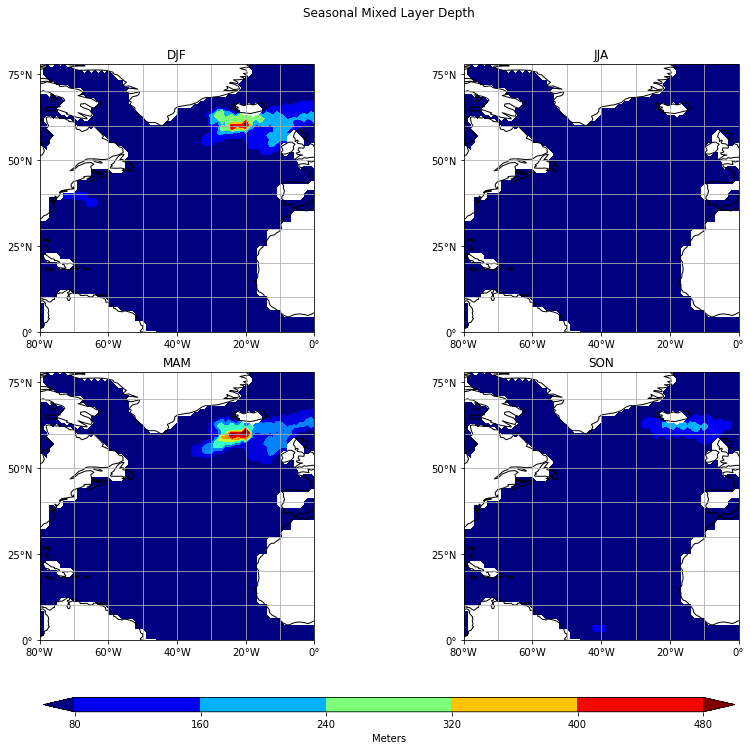

In [8]:
ds_seasonal = ds_mld.groupby('time.season').mean('time')

fig, ax = plt.subplots(nrows=2,ncols=2, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(12,10))

ax = ax.flatten()

for i, seas in enumerate(ds_seasonal['season']):
    cs = ax[i].contourf(ds_seasonal['lon'],ds_seasonal['lat'],ds_seasonal['mld'].sel(season=seas)/100
                        ,cmap='jet',transform=ccrs.PlateCarree(),extend='both')
    ax[i].set_extent([-80,0,0,75])
    #Longitude Labels
    ax[i].set_xticks(np.arange(-80,1,20),crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax[i].xaxis.set_major_formatter(lon_formatter)
    
    #Latitude Labels
    ax[i].set_yticks(np.arange(0,76,25),crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax[i].yaxis.set_major_formatter(lat_formatter)

    
    ax[i].coastlines()
    ax[i].gridlines()
    ax[i].set_title(seas.values)
    
#Make room for colorbar
fig.subplots_adjust(bottom=0.1,top=0.9,left=0.05,right=0.95,wspace=0.2,hspace=0.15)
cbar_ax = fig.add_axes([0.1,0,0.8,0.02])
cbar=fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='Meters')
plt.suptitle('Seasonal Mixed Layer Depth')
#plt.tight_layout()

### Getting the AMOC index and its annual mean values

In [29]:
ds_amoc = xr.open_dataset('Data/cesm_maxAMOC.nc')
ds_amoc = ds_amoc.groupby('time.year').mean('time')

### Using the function utils.selectSeason to get the winter (DJF) mixed-layer depth

In [30]:
ds_mld_seas = ut.selectSeason(ds_mld,'MAM')

Now, we need to find the mean and standard deviation of the AMOC for plotting and for testing it against the MLD

In [31]:
amoc = ds_amoc['maxAMOC']

mu_amoc = amoc.mean('year')
sd_amoc = amoc.std('year')
mu_amoc
print('Mean AMOC strength:', np.round(mu_amoc.values,2), 'Sverdrups')
print('Standard Deviation of the AMOC:',np.round(sd_amoc.values,2), 'Sverdrups')

Mean AMOC strength: 14.76 Sverdrups
Standard Deviation of the AMOC: 0.75 Sverdrups


Plotting the AMOC at 30N

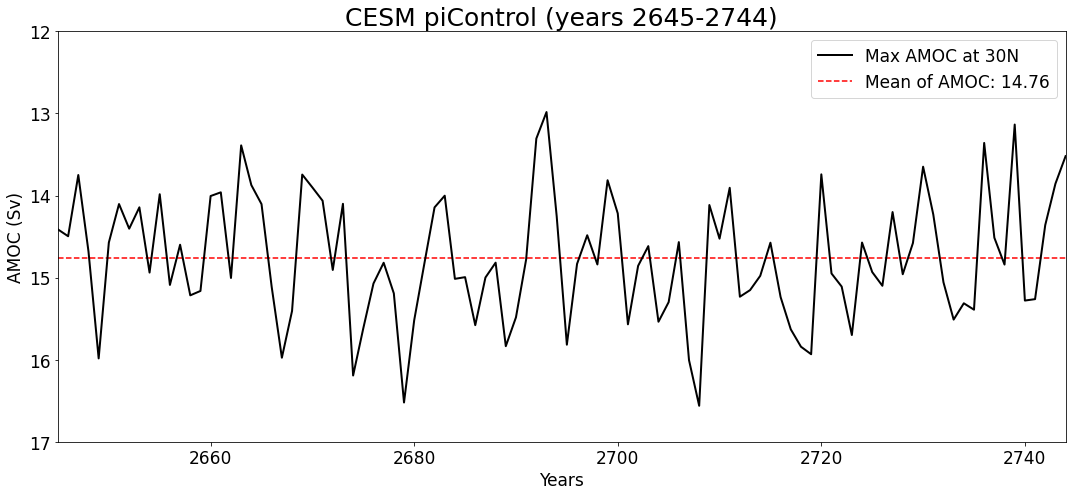

In [32]:
yrs = np.arange(2645,2745)
#yrs = ds_amoc['year']
fig = plt.figure(figsize=(15,7))
fs = 17
ax = plt.axes()
ax.plot(yrs,amoc,'k', linewidth=2.)
ax.tick_params(labelsize=fs)
ax.hlines(mu_amoc,min(yrs),max(yrs),'r',linestyles='--')
ax.legend(['Max AMOC at 30N', 'Mean of AMOC: '+str(np.round(mu_amoc.values,2))],fontsize=fs)


plt.xlabel('Years',fontsize=fs)
plt.ylabel('AMOC (Sv)',fontsize=fs)

plt.axis([min(yrs),max(yrs),17,12])
plt.title('CESM piControl (years 2645-2744)',fontsize=25)
plt.tight_layout()

### Getting the MLD for periods where the AMOC is both above and below one standard deviation of the mean

In [33]:
highAMOC = ds_amoc.where(amoc>mu_amoc)#(mu_amoc+sd_amoc))
lowAMOC = ds_amoc.where(amoc<mu_amoc)#(mu_amoc-sd_amoc))

counts = [highAMOC.count(dim='year').values,  lowAMOC.count(dim='year').values]
mldHigh = ds_mld_seas.sel(year=highAMOC.dropna(dim='year')['year']).mean(dim='year')
mldLow = ds_mld_seas.sel(year=lowAMOC.dropna(dim='year')['year']).mean(dim='year')


### Plotting the MLD for above and below average MLD's

Text(0.5, 0.98, 'Mixed Layer Depth')

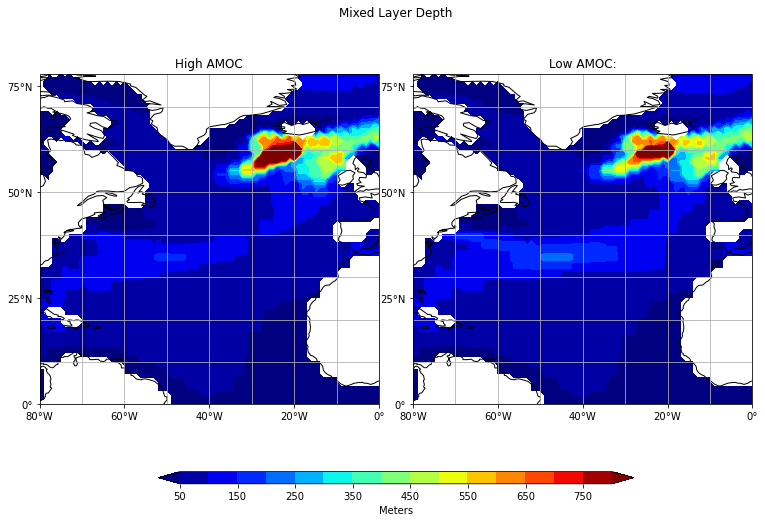

In [34]:
MLDtypes = [mldHigh['mld']/100,mldLow['mld']/100]

fig,ax = plt.subplots(nrows=1,ncols=2,subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(11.,8.5))
ax = ax.flatten()

clevs = np.arange(50,801,50)
titles = ['High AMOC', 'Low AMOC:']#, 'Difference in AMV\'s']
for i, t in enumerate(titles):
    ax[i].set_extent([-80,0,0,75])
    cs = ax[i].contourf(lon,lat,MLDtypes[i],cmap='jet',transform=ccrs.PlateCarree(),extend='both',levels=clevs)
    
    #Longitude Labels
    ax[i].set_xticks(np.arange(-80,1,20),crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax[i].xaxis.set_major_formatter(lon_formatter)
    
    #Latitude Labels
    ax[i].set_yticks(np.arange(0,76,25),crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax[i].yaxis.set_major_formatter(lat_formatter)

    
    ax[i].coastlines()
    ax[i].gridlines()
    ax[i].set_title(t)
    
#Make room for colorbar
fig.subplots_adjust(bottom=0.3,top=0.9,left=0.05,right=0.95,wspace=0.1,hspace=0.4)
cbar_ax = fig.add_axes([0.2,0.2,0.6,0.02])
cbar=fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='Meters')
plt.suptitle('Mixed Layer Depth')

### Adding a plot of the difference between MLD's when the AMOC is above and below the mean (high-low)

Text(0.5, 1.0, 'High AMOC - Low AMOC')

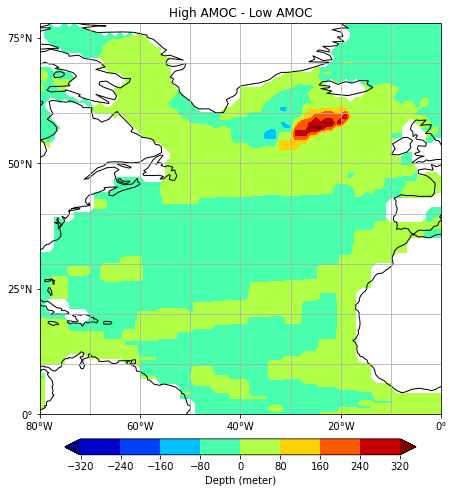

In [35]:
mldDiff = mldHigh['mld']/100 - mldLow['mld']/100

clevs = np.arange(-320,321,80)

fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-80,0,0,75])

cs = ax.contourf(lon,lat,mldDiff,cmap='jet',levels=clevs,extend='both', transform=ccrs.PlateCarree())
#adding coastlines
ax.coastlines()
#Add Gridlines
ax.gridlines()

#Defining the x-ticks for longitude
ax.set_xticks(np.arange(-80,1,20),crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

#Now getting the y-ticks
ax.set_yticks(np.arange(0,76,25),crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

#Calling the colorbar
cbar = plt.colorbar(cs,orientation='horizontal',shrink=0.7, pad = 0.05, label='Depth (meter)')
plt.title('High AMOC - Low AMOC')

### Now, looking at the correlation between the AMOC and MLD in the Northern Atlantic

In [36]:
rMap = xr.corr(amoc,ds_mld_seas['mld']/100,dim='year')

Text(0.5, 1.0, 'CESM Preindustrial Control')

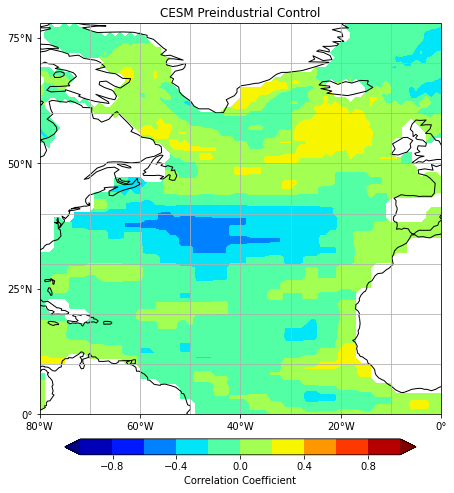

In [37]:
clevs = np.arange(-1,1.1,0.2)
fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-80,0,0,75])

cs = ax.contourf(lon,lat,rMap,cmap='jet',extend='both',levels=clevs, transform=ccrs.PlateCarree())
#adding coastlines
ax.coastlines()
#Add Gridlines
ax.gridlines()

#Defining the x-ticks for longitude
ax.set_xticks(np.arange(-80,1,20),crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

#Now getting the y-ticks
ax.set_yticks(np.arange(0,76,25),crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

#Calling the colorbar
cbar = plt.colorbar(cs,orientation='horizontal',shrink=0.7, pad = 0.05, label='Correlation Coefficient')
plt.title('CESM Preindustrial Control')

### Regressing the MLD onto the AMOC and plotting it onto a map

In [38]:
nx = len(ds_mld_seas['lat'])
ny = len(ds_mld_seas['lon'])

p_array = np.zeros((nx,ny))
r_array = np.zeros((nx,ny))
m_array = np.copy(p_array)

for i in range(nx):
    for j in range(ny):
        x = amoc
        y = ds_mld_seas['mld'][:,i,j]/100
        
        m,b,r,p,e = sps.linregress(x,y)
        
        m_array[i,j]=m
        r_array[i,j]=r
        p_array[i,j]=p

In [39]:
mask_sig = np.where(p_array<0.05,m_array,np.nan)

### Plotting the regression coefficients

Text(0.5, 1.0, 'CESM Preindustrial Control')

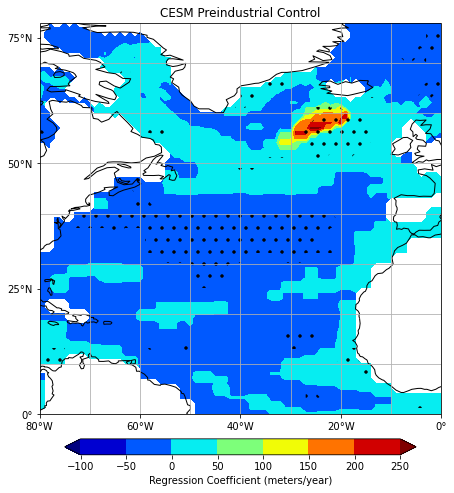

In [40]:
fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-80,0,0,75])

cs = ax.contourf(lon,lat,m_array,cmap='jet',extend='both', transform=ccrs.PlateCarree())
ax.contourf(lon,lat,mask_sig,[0,1],colors='None',hatches=['.','.'],extend='both', transform=ccrs.PlateCarree(),alpha=0)

#adding coastlines
ax.coastlines()
#Add Gridlines
ax.gridlines()

#Defining the x-ticks for longitude
ax.set_xticks(np.arange(-80,1,20),crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

#Now getting the y-ticks
ax.set_yticks(np.arange(0,76,25),crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

#Calling the colorbar
cbar = plt.colorbar(cs,orientation='horizontal',shrink=0.7, pad = 0.05, label='Regression Coefficient (meters/year)')
plt.title('CESM Preindustrial Control')